In [62]:
#imports
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import xarray as xr
import geoviews as gv
import geoviews.feature as gf

# First, we load in data from the OCADS OA indicators dataset

In [63]:
#run the file containing the script to download OCADS data
%run read_data.py

In [64]:
#read in pH, Sea Surface Temperature, and CO2 data

pH_data = download_OCADS_data("pHT", "historical")
SST_data = download_OCADS_data("Temperature", "historical")
fCO2_data = download_OCADS_data("fCO2", "historical")

In [65]:
#convert data to xr Data Arrays

pH_global = pH_data['pHT']['historical']
SST_global = SST_data['Temperature']['historical']
fCO2_global = fCO2_data['fCO2']['historical']

#show pH DataArray as a check
pH_global

<xarray.DataArray 'pHT' (time: 18, lat: 180, lon: 360)> Size: 9MB
[1166400 values with dtype=float64]
Coordinates:
  * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
Dimensions without coordinates: lat, lon
Attributes:
    long name:  pH on total hydrogen ion scale
    CF_name:    sea_water_ph_reported_on_total_scale
    units:      N/A

In [66]:
#convert lat from 0 - 180 to -90 - 90 and convert lon from 0 - 360 to -180 - 180

global_das = [pH_global, SST_global, fCO2_global]


for da in global_das:
   
    da.coords['lon'] = da.coords['lon'] - 180 % 360 + 200 # adding 180 does not align longitudes correctly for some reason
    da.coords['lat'] = (da.coords['lat'] - 90)
    da = da.sortby(da.lon)
   
    print(da.attrs['long name'], ": ", da.lon)

pH on total hydrogen ion scale :  <xarray.DataArray 'lon' (lon: 360)> Size: 3kB
array([ 20,  21,  22, ..., 377, 378, 379], shape=(360,))
Coordinates:
  * lon      (lon) int64 3kB 20 21 22 23 24 25 26 ... 374 375 376 377 378 379
sea surface temperature (ITS90) :  <xarray.DataArray 'lon' (lon: 360)> Size: 3kB
array([ 20,  21,  22, ..., 377, 378, 379], shape=(360,))
Coordinates:
  * lon      (lon) int64 3kB 20 21 22 23 24 25 26 ... 374 375 376 377 378 379
fugacity of carbon dioxide :  <xarray.DataArray 'lon' (lon: 360)> Size: 3kB
array([ 20,  21,  22, ..., 377, 378, 379], shape=(360,))
Coordinates:
  * lon      (lon) int64 3kB 20 21 22 23 24 25 26 ... 374 375 376 377 378 379


# Next, lets create an example plot to visualize the data. This will be a spatial map of the pH data in a random year (2000)

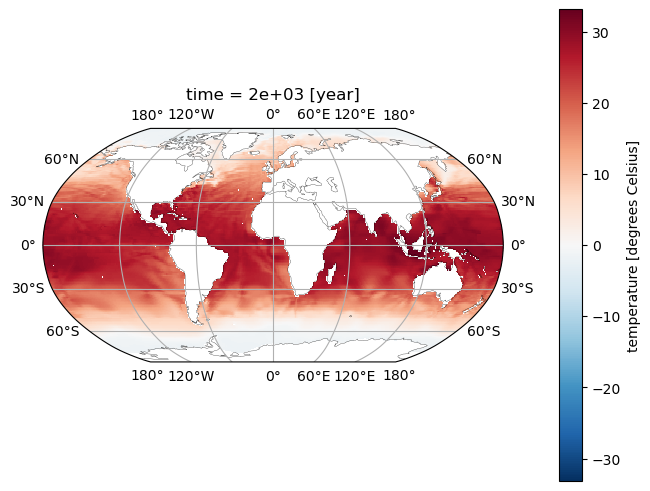

In [67]:
# create a figure
fig = plt.figure(constrained_layout=True)

# assign axis and define the projection -  centred in pacific
ax = plt.axes(projection = ccrs.Robinson())

# add coastlines
ax.coastlines(linewidth=0.2)

# add gridlines (lon and lat)
ax.gridlines(draw_labels=True)

# example plot of pH in year 2000
SST_global.sel(time=2000).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

# Here, we aim to show a time series of the anomalies of our chosen variables

In [68]:
#Define climatology period (in this case 1850 - 1870). This dataset is only resolved decadally so there are only 3 data points

pH_30yr = pH_global.sel(time=slice(1850, 1870))
pH_clim = pH_30yr.mean(dim='time')

SST_30yr = SST_global.sel(time=slice(1850, 1870))
SST_clim = SST_30yr.mean(dim='time')

fCO2_30yr = fCO2_global.sel(time=slice(1850, 1870))
fCO2_clim = fCO2_30yr.mean(dim='time')

In [69]:
#Calculate anomaly using climatology
pH_anom = pH_global - pH_clim
SST_anom = SST_global - SST_clim
fCO2_anom = fCO2_global - fCO2_clim

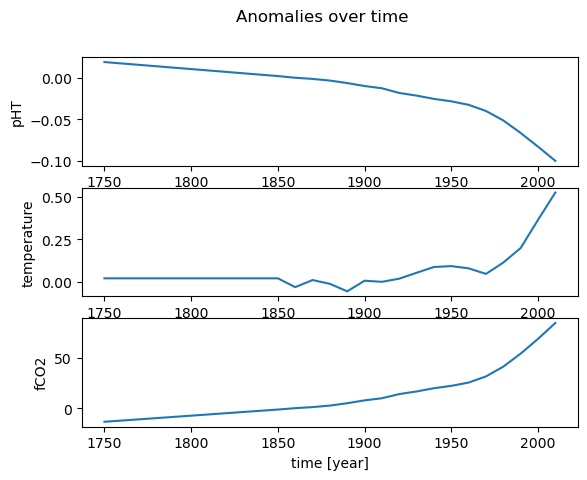

In [70]:
#Plot anomaly over time
fig, axs = plt.subplots(3)
fig.suptitle('Anomalies over time')

pH_anom.mean(dim=['lat', 'lon']).plot(ax=axs[0])
SST_anom.mean(dim=['lat', 'lon']).plot(ax=axs[1])
fCO2_anom.mean(dim=['lat', 'lon']).plot(ax=axs[2])

# Now we want to recreate this for our areas of interest

In [71]:
#Define bounds for areas of interest
WA_lims = {'lat':(0, 27), 'lon':(-21, 27)}

#Create new DataArrays with the area of interest selected
pH_WA = pH_global.where((pH_global.lat > WA_lims['lat'][0]) & (pH_global.lat < WA_lims['lat'][1]) & (pH_global.lon > WA_lims['lon'][0]) & (pH_global.lon < WA_lims['lon'][1]))
SST_WA = SST_global.where((SST_global.lat > WA_lims['lat'][0]) & (SST_global.lat < WA_lims['lat'][1]) & (SST_global.lon > WA_lims['lon'][0]) & (SST_global.lon < WA_lims['lon'][1]))
fCO2_WA = fCO2_global.where((fCO2_global.lat > WA_lims['lat'][0]) & (fCO2_global.lat < WA_lims['lat'][1]) & (fCO2_global.lon > WA_lims['lon'][0]) & (fCO2_global.lon < WA_lims['lon'][1]))

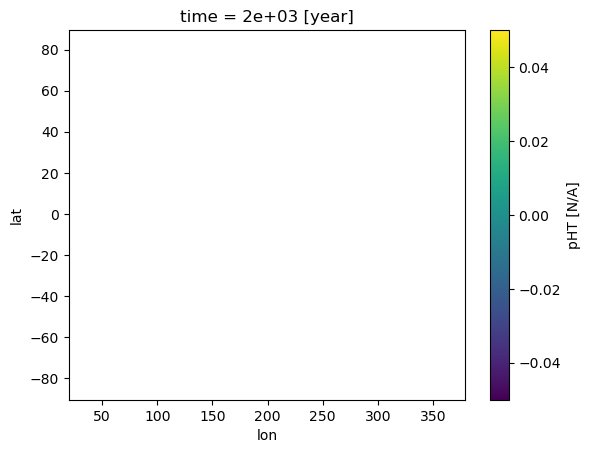

In [72]:
#Lets show our area of interest
pH_WA.sel(time=2000).plot()

In [73]:
#Again, define climatology and anomaly

pH_30yr_WA = pH_WA.sel(time=slice(1850, 1870))
pH_clim_WA = pH_30yr_WA.mean(dim='time')

SST_30yr_WA = SST_WA.sel(time=slice(1850, 1870))
SST_clim_WA = SST_30yr_WA.mean(dim='time')

fCO2_30yr_WA = fCO2_WA.sel(time=slice(1850, 1870))
fCO2_clim_WA = fCO2_30yr_WA.mean(dim='time')

pH_anom_WA = pH_WA - pH_clim_WA
SST_anom_WA = SST_WA - SST_clim_WA
fCO2_anom_WA = fCO2_WA - fCO2_clim_WA

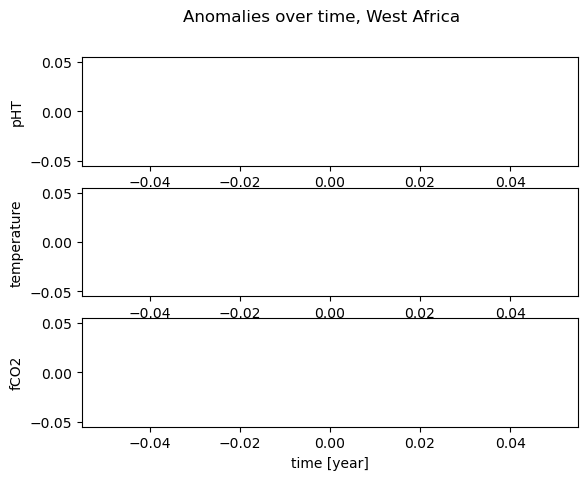

In [74]:
#And plot again
fig, axs = plt.subplots(3)
fig.suptitle('Anomalies over time, West Africa')

pH_anom_WA.mean(dim=['lat', 'lon']).plot(ax=axs[0])
SST_anom_WA.mean(dim=['lat', 'lon']).plot(ax=axs[1])
fCO2_anom_WA.mean(dim=['lat', 'lon']).plot(ax=axs[2])

In [75]:
fCO2_anom_WA

<xarray.DataArray 'fCO2' (time: 18, lat: 180, lon: 360)> Size: 9MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(18, 180, 360))
Coordinates:
  * time     (time) float64 144B 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
  * lat      (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89
  * lon      (lon) int64 3kB 20 21 22 23 24 25 26 ... 374 375 376 377 378 379